In [7]:
# %cd /content/drive/MyDrive/Computer_Vision/SatelliteDataset/images/train
# !ls


'kmd;m;lfewk'

In [81]:
import albumentations as A
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import re

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [59]:
def load_mask(path: str):
    mask = Image.open(path)
    mask = np.array(mask)/255
    mask = mask.transpose((2,0,1))
    new_channel = np.where(np.sum(mask,axis=0) == 0, 1, 0)
    mask = np.concatenate([mask, new_channel[None,:,:]])
    return mask.transpose((1,2,0))

def load_image(path: str):
    img = Image.open(path)
    img = np.array(img)/255

    image_without_alpha = img[:,:,:3]

    return image_without_alpha

In [61]:
configs = {
    "dataset_dir": "satellite_dataset",
    "pad_shape": (9,9,6,6),
    # "pad_shape": (0,0,0,0),
    "train_batch_size": 4,
    "shuffle": True,
    "init_lr": 0.001,
    "epochs": 10
}

In [69]:
def sortByNumber(path):
  return int(re.findall(r'\d+', path)[0])

IMAGE_HEIGHT=180
IMAGE_WIDTH=270

class SatelliteDataset():
    def __init__(self, ds_type = "train", path=configs['dataset_dir'], pad_shape = configs['pad_shape']):

        self.ds_type = ds_type
        self.img_dir = os.path.join(path, f"images/{ds_type}")
        self.mask_dir = os.path.join(path, f"mask/{ds_type}")
        self.pad_shape = pad_shape

        self.img_pathes = []
        self.mask_pathes = []

        for file_path in os.walk(self.img_dir):
            self.img_pathes.extend(list(filter(lambda x: x.endswith(".png"), file_path[-1])))

        for file_path in os.walk(self.mask_dir):
            self.mask_pathes.extend(list(filter(lambda x: x.endswith(".png"), file_path[-1])))

        self.img_pathes.sort(key=sortByNumber, reverse=False)
        self.mask_pathes.sort(key=sortByNumber, reverse=False)

    def __getitem__(self, index):
        mask_path = self.mask_pathes[index]
        img_path = self.img_pathes[index]

        mask = load_mask(os.path.join(self.mask_dir, mask_path))
        img = load_image(os.path.join(self.img_dir, img_path))
        a1 = []
        if self.ds_type == "train":
          a1 = [
                A.RandomCrop(p=0.25, height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
                # A.RandomRotate90(p=0.5),
                A.HorizontalFlip(p=0.25),
                A.VerticalFlip(p=0.25),
                A.Transpose(p=0.25),
                A.OneOf([
                  A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                  A.GridDistortion(p=0.5),
                  A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                  ], p=0.5),
                A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            ]
        else:
            a1 = [
                A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            ]

        aug = A.Compose(
            a1,
            is_check_shapes=False
          )
        aug_data = aug(image=img, mask=mask)
        img = aug_data['image']
        mask = aug_data['mask']

        pad_transform = torch.nn.ZeroPad2d(self.pad_shape)
        img = pad_transform(torch.FloatTensor(img.transpose((2,0,1))))
        mask = pad_transform(torch.FloatTensor(mask.transpose((2,0,1))))

        return img, mask

    def __len__(self):
        return len(self.img_pathes)

In [64]:
train_dataset = SatelliteDataset(ds_type = "train", path = configs['dataset_dir'])
# val_dataset = SatelliteDataset(ds_type = "val", path = configs['dataset_dir'])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=configs['train_batch_size'], shuffle=configs['shuffle'])
# val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=configs['train_batch_size'], shuffle=configs['shuffle'])

In [65]:
import segmentation_models_pytorch as smp

model = smp.Unet('resnet50', encoder_weights='imagenet', in_channels=3, classes=4, activation='softmax')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=configs['init_lr'])
loss = torch.nn.CrossEntropyLoss()

In [70]:
count = 0
for epoch in range(configs['epochs']):
  loss_list = []

  for img, mask in train_dataloader:
    img = img.to(device)

    mask = mask.to(device)
    print(count)
    count += 1
    predict = model(img)
    loss_value = loss(mask, predict)

    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

    loss_list.append(loss_value.item())

  print(f"loss: {np.mean(loss_list)}")


0


/Users/anton/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [72]:
# state_dict = model.state_dict()
# torch.save(state_dict,'model_weights_2024.pth')
w = torch.load('model_weights_2024.pth', map_location=torch.device('cpu'))
model.load_state_dict(w)

<All keys matched successfully>

mIoU > 0.70

In [66]:
def calc_IoU(mask, predict):

  mask = np.array(torch.argmax(mask, dim=0))
  predict = np.array(torch.argmax(predict, dim=0))

  IoU = []
  for i in range(4):
    m = np.where(mask == i, 1, 0)
    p = np.where(predict == i, 1, 0)
    intersect = np.sum(m * p)
    IoU.append(intersect/(np.sum(m) + np.sum(p) - intersect))

  return np.mean(IoU)

In [ ]:
loss_list = []
mIoU = []

for img, mask in val_dataloader:
    img = img.to(device)
    mask = mask.to(device)

    predict = model(img)

    loss_value = loss(mask, predict)
    loss_list.append(loss_value.item())

    mask = mask.to('cpu')
    predict = predict.to('cpu')
    loss_list.append(loss_value.item())

    for index in range(configs['train_batch_size']):
      mIoU.append(calc_IoU(mask[index], predict[index]))

    print(f"mIoU: {np.mean(mIoU)}")

# print(f"loss: {np.mean(loss_list)}")



In [54]:
!ls satellite_dataset/images/train

img_resize_0.png    img_resize_1602.png img_resize_2214.png img_resize_2803.png
img_resize_1.png    img_resize_1605.png img_resize_2215.png img_resize_2804.png
img_resize_100.png  img_resize_1606.png img_resize_2217.png img_resize_2805.png
img_resize_1003.png img_resize_1609.png img_resize_2218.png img_resize_2806.png
img_resize_1004.png img_resize_1610.png img_resize_2219.png img_resize_2807.png
img_resize_1006.png img_resize_1611.png img_resize_2221.png img_resize_2808.png
img_resize_1007.png img_resize_1612.png img_resize_2222.png img_resize_2809.png
img_resize_1009.png img_resize_1614.png img_resize_2223.png img_resize_281.png
img_resize_101.png  img_resize_1615.png img_resize_2224.png img_resize_2810.png
img_resize_1010.png img_resize_1616.png img_resize_2225.png img_resize_2811.png
img_resize_1012.png img_resize_1618.png img_resize_2227.png img_resize_2812.png
img_resize_1013.png img_resize_1619.png img_resize_2228.png img_resize_2813.png
img_resize_1014.png img_resize_162.png  i

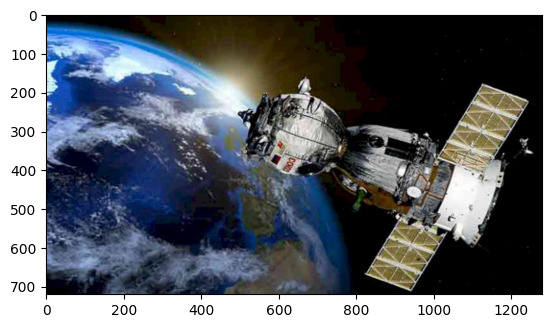

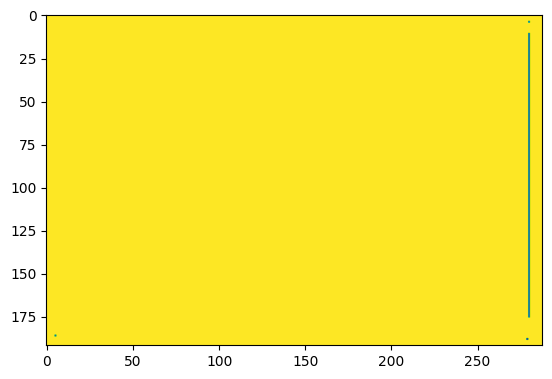

In [73]:
def load(path):
  img = load_image(path)
  aug = A.Compose(
      [A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH)],
      is_check_shapes=False
  )
  aug_data = aug(image=img)
  img = aug_data['image']
  pad_transform = torch.nn.ZeroPad2d((9,9,6,6))
  plt.imshow(load_image(path))
  plt.show()

  return pad_transform(torch.FloatTensor(img.transpose((2,0,1))))

img = load("satellite_dataset/images/train/img_resize_0.png")

plt.imshow(torch.argmax(model(img[None,:,:,:])[0], dim = 0))


In [ ]:
plt.imshow(load_image('img_resize_0.png'))

In [80]:
# AB = [[2,1],[2,2],[5,1],[1,3]]

AB = []
N = int(input())

for _ in range(N):
    a, b = map(int, input().split())
    AB.append([a,b])

AB.sort(key=sum, reverse=True)

B = 0
A = sum([a for a, b in AB]) 
k = 0
print(A)

for a, b in AB:
    print(a,b)
    if B <= A:
        B += a + b 
        A -= a
        k += 1    

print(f"k: {k}")

10
5 1
2 2
1 3
2 1
k: 1


In [106]:
img = load_image(os.path.join(configs['dataset_dir'], "mask/train", 'img_resize_6_mask.png'))

In [111]:
len(img.ravel())

2764800

In [110]:
720*1280*3

2764800

In [123]:
from functools import wraps
def my_decorator(f):
    @wraps(f)
    def wrapper(*args, **kwds):
        print(f'Calling decorated function: {f.__name__}')
        return f(*args, **kwds)
    return wrapper

@my_decorator
def example():
    """Docstring"""
    print('Called example function')

example.__name__

print(f"example.__doc__ {example.__doc__}" )
example()

example.__doc__ Docstring
Calling decorated function: example
Called example function


In [14]:
def find(arr, X):
    left = 0
    right = len(arr) - 1
    best_values = left, right

    while left < right:
        if abs(arr[left]+arr[right] - X) < abs(arr[best_values[0]]+arr[best_values[1]]):
            best_values = left, right
            print(best_values, "while best_values")

            if arr[left]+arr[right] == X:
                break
            
            if arr[left]+arr[right] > X:
                right -= 1
            else:
                left += 1


    return best_values

# assert(find([1,1,3, 5, 8, 9], 7) == 0)
# find([1,1,3, 5, 8, 9, 12, 18], 23)


def max_lens(text):
    d = dict()
    max_len = 0
    current_len = 0

    for i in range(len(text)):
        if text[i] not in d or d[text[i]] < i - current_len:
            current_len += 1
        else:
            current_len = i - d[text[i]]

        max_len = max(max_len, current_len)

        d[text[i]] = i

    return max_len

max_lens("ryfyfuy")




3

In [107]:
set(list((img).ravel()))

{0.0, 1.0}

In [1]:
f1 = 1
f2 = 1

for i in range(2, 10):
    f1, f2 = f2, f1 + f2
    print(f1, f2)

1 2
2 3
3 5
5 8
8 13
13 21
21 34
34 55


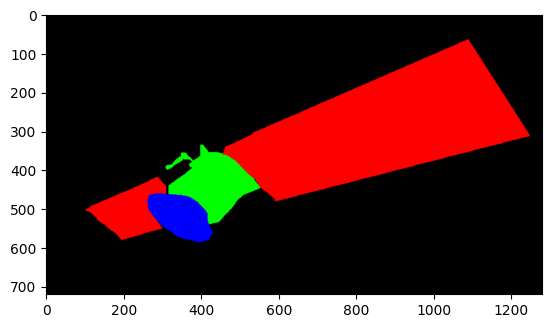

In [97]:
plt.imshow(load_image(os.path.join(configs['dataset_dir'], "mask/train", 'img_resize_6_mask.png')))

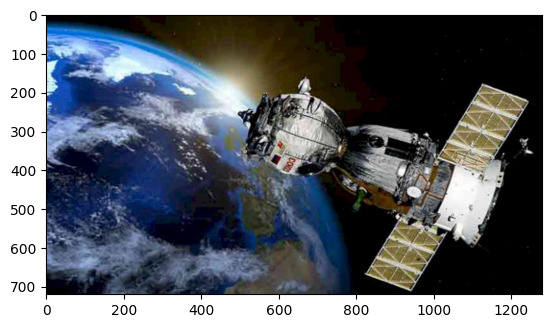

In [83]:
plt.imshow(load_image(os.path.join(configs['dataset_dir'], "images/train", 'img_resize_0.png')))